### TODO / Backlog:

- Use GridsearchCV to find the optimal number of trees for random-forest regressor.
- Should we consider log of volume and log of moving averages for the plots?

### Undergoing:
- (29/12/19) Feature engineer and test regression for _REALIZED_VOL and _VOL_PROXY 
- (29/12/19) Shifted the series within the design matrix:
    - to match the dimensions, had to start from the second observation for predicted variable
    - need to make sure it makes sense, as now, most regression R² are negative

### Assumptions undertaken | achieved tasks:
- (29/12/19) split main-function into smaller functions like on-chain transaction transform, to ease code maintenance
- (29/12/19) Add volatility proxy by computing the square of log returns
- (29/12/19) updating variables / features names to differentiate developer variables (ones we created) with variables from raw data.
    - (29/12/19) We identify developer variables by an underscore preceding an all capitalized variable name.
- (26/12/19) Added the realized volatility according to lecture7 slide 18/28 Advanced derivatives definition i.e.: 
    - $$\sigma_R = 100 \cdot sqrt( \frac{252}{N_{days}} \cdot \sum^{N_{days}}_{i=1} (ln(\frac{S_i}{S_{i-1}}))^2 ) $$ 
    - ~~(26/12/19) yields NaN only, need to figure out why~~ - (29/12/19) figured I used price dataframe instead of data dataframe - now we have values

- Include transactions FROM exchanges to any wallet, merge the two dataframes (TO and FROM exchanges). 
    - Queried the FROM exchange dataframe with a new SQL query
    - Union the two datasets and drop the duplicates on the transaction_hash
    - compute the corresponding count of transactions to exchanges
    - TODO (as of 23/12/19): 
        - ~~update overleaf with new SQL query~~ (26/12/19)
        - ~~make sure the from_exchange and to_exchange sum variables work as intended~~ (29/12/19)
    
- Plot ACF & PACF to obtain the good number of lags + complete the overleaf part.
    - Number of lags determined by the minimization of the BIC
    - ACF & PACF are plot
    - TODO: 
        - overleaf
- Re-queried data with daily intervals instead of hourly returns
    - updated the period burn to match new frequency
    - updated the rolling plots to match new frequency
    - TODO: ~~update overleaf~~ (26/12/19)
    
- add intercept in design matrix
- removal of all transactions with zero 'close' & removal of first two weeks of each trading period  
    - Assumption: on-chain transactions prior to quotation are left aside.
    - Upsides: allows to remove prices equal to 0 and then remove first two weeks of trading (to avoid possible extreme outliers)
- include back on-chain transactions FROM exchanges and add a dummy variable identifying whether it comes FROM or TO an exchange
    - added a count variable for transactions from one exchange's wallet to another
    - ~~underlying data in its current iteration (as of 21/12/19) only has transactions TO exchanges' wallets and not FROM as i.e. if someone had sent money FROM the exchange TO an unknown wallet~~
    - ~~in its previous iteration, we missed transactions from one exchange to another, while they were legitimate~~

We will consider the GARCH(1,1) with Student-t innovations model of the log-returns process \{$y_t$, $t\in \mathcal{Z}$\}, for $t = 1, \dots, T$:

$$    y_t = \epsilon_t \cdot h_t^{1/2} $$

where $\epsilon_t$ is a sequence of $i.i.d.$ variables $\sim$ ${\mathcal{t}}(\nu)$, 

$$ h_t = \omega + \alpha \cdot y^2_{t-1} + \beta \cdot h_{t-1}$$

for $\omega > 0$; $\alpha,\beta \geq 0$; ${\mathcal{t}}(\nu)$ denotes the Students-t distribution with $\nu$ degrees of freedom. The restriction on the GARCH parameters $\omega$, $\alpha$, $\beta$ guarantee the conditional variance's positivity.

The term $(\alpha + \beta)$ is the degree of persistence in the autocorrelation of the squares which controls the intensity of the clustering in the variance process. With a value close to one, past shocks and past variances will have a longer impact on the future conditional variance.


In [1]:
import numpy as np 
import pandas as pd 
import os
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import scipy
import sklearn
import time
import os.path
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, StudentsT

In [2]:
token_data = pd.read_csv('ethereum_erc20_tokens.csv')

In [3]:
'''
This function aims to format on-chain raw data into proper format. 
We create dummy variables which identify whether a transactions comes FROM an exchange
and / or TO an exchange
'''
def format_on_chain_df(dataframe_path, token_initials):

    # Read the .csv file containing all exchanges relevant data
    exchange_data = pd.read_csv('all_exchanges.csv')
    
    # example of dataframe path: './data/{}/raw_big_query.csv'.format{token_initials}
    df = pd.read_csv(dataframe_path.format(token_initials)) 
    df.block_timestamp = (
        df
        .block_timestamp
        .apply(
            lambda x: datetime.strptime(x[:-6],'%Y-%m-%d %H:%M:%S') 
        )
    )
    
    # transactions towards the different exchanges
    exchange_txn_count = (
        df
        .groupby('to_address')
        .count()
        .reset_index()
        .loc[:,['to_address','token_address']]
        .merge(exchange_data, right_on='Address',left_on='to_address')
        .drop(['Address','to_address', 'Txn Count', 'Balance'], axis = 1)
        .rename(columns={'token_address':'transaction_count'})
        .sort_values('transaction_count', ascending=False)
    )
    
    #display(exchange_txn_count.head(20))
    tokens.loc[tokens.initials == token_initials,'most active exchange'] = exchange_txn_count.iloc[0,1]

    # We convert the values (stored as strings) to floats
    df.value=df.value.astype(float)

    exchange_data.Address

    # We create a dummy variable to identify transactions
    # from one exchange's wallet to any address   
    df['_FROM_EXCHANGE'] = 0
    # If the 'from_address' at the given raw IS IN the
    # exchanges' wallet addresses, we set the value to 1
    df.loc[df['from_address'].isin(exchange_data.Address), '_FROM_EXCHANGE'] = 1
    
    # We create a dummy variable to identify transactions
    # TO one exchange's wallet from any wallet   
    df['_TO_EXCHANGE'] = 0
    # If the 'to_address' at the given raw IS IN the
    # exchanges' wallet addresses, we set the value to 1
    df.loc[df['to_address'].isin(exchange_data.Address), '_TO_EXCHANGE'] = 1
        
    trans = df
    print('We found {} transactions'.format( df.shape[0]), 'for ',dataframe_path )
    tokens.loc[tokens.initials == token_initials,'transactions to exchanges'] = df.shape[0]
        
    address_tran_counts = (
        trans
        .groupby('from_address')
        .count()
        .sort_values(by='value', ascending = False)
        .to_address
    )
    
    trans = (
        df
        .sort_values('block_timestamp')
        .reset_index()
        .drop('index', axis=1)
    )
    
    trans = trans.rename(columns={'block_timestamp': 'time'})

    # We transform the times UTC to naive times
    trans.time = trans.time.values

    min_date = datetime.timestamp(trans.time[0])
    max_date = datetime.timestamp(trans.time.iloc[-1])
    max_date, min_date
    
    return(trans)

In [4]:
'''
This function aims to format the off-chain raw data into a proper format
'''

def format_off_chain_df(dataframe_path, initial_date = None):
    
    price_raw = pd.read_csv(dataframe_path)
    price = price_raw
    price = price.sort_values('time').reset_index()

    price.loc[:,'time_readable'] = (
        price
        .time
        .apply(lambda x:datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S') )
    )
    
    # We convert the price dates into datetime objects
    price.time=price.time.apply(lambda x: datetime.fromtimestamp(x))

    if initial_date:
        price = price.loc[price.time > initial_date]

    # "volumeto" refers to the volume in the currency that is being traded against (e.g. BTC for ETH/BTC)
    # "volumefrom" refers to the volume in the base currency that things are traded into.
    price = (
        price
        .drop(
            ['time_readable', 'conversionSymbol','conversionType', 'open', 'volumefrom','index'],
            axis=1
        )
    )
    
    # We consider the BTC volume as what we refer to as 'volume'
    price = (
        price
        .rename(columns={'volumeto':'volume'}) 
        .drop('Unnamed: 0', axis=1)
    )
    
    # filters out all zero prices
    price = price[(price[['close']] != 0).all(axis=1)]
    print('We have {} off-chain daily intervals.'.format( price.shape[0]) )
    
    
    return(price)

In [5]:
'''
This function aims to compute the on-chain aggregates, i.e.
since we need to match the frequency of off-chain transactions
with on-chain ones, we need to aggregate from unique transactions
to the desired aggregation level, e.g. 1 day.

We perform 'count' aggregations to obtain the number of total 
on-chain transactions of interest, and its breakdown into
transactions FROM exchanges and transactions TO exchanges.
We compute the sum of sent tokens over the desired frequency.

We return the merge of on-chain and off-chain dataframes enriched with 
the computed aggregates.
'''
def compute_aggregates(price, trans):
        
    # We compute the returns of the closing prices
    price.loc[:,'_RETURNS'] = np.log(price['close']).diff()
        
    # In order to transform dates to non local time
    trans.loc[:,'time']= trans.time.values

    min_time, max_time = price.time.iloc[[0,-1]].values
    min_trans_time, max_trans_time = trans.time.iloc[[0,-1]].values

    # We only keep the transactions for which we have price data
    # trans = trans.loc[(trans['time'] >= min_time)]   
    '''
    TEST PURPOSE: 
    we only keep the transactions for which we have on-chain data
    '''
    print('Current maximum off_chain time is {}'.format(max_time), 'as of {}'.format(date.today()))
    print('Current maximum on_chain time is {}'.format(max_trans_time), 'as of {}'.format(date.today()))
    price = price.loc[(price['time'] <= max_trans_time)]   
        
    '''
    With the on-chain transactions,
    We create bins to match the time frequency of off-chain
    data. 
    ''' 
    cut = pd.cut(trans.time, bins = price.time, duplicates='drop')

    '''
    GOAL: merge on-chain and off-chain datasets.
    PROCEDURE:
    Group by the number of tokens exchanged (value) and compute the sum
    and count of this feature.
    Yields: 'onchain_volume' & 'onchain_trans'
    Perform the same by grouping by 'from_exchange' dummy variable
    and taking a count of it, to obtain the number of 
    transactions coming FROM exchanges
    '''
    data = price

    for _GROUPBY in ['value','_FROM_EXCHANGE','_TO_EXCHANGE']:
        # sum variable of FROM exchanges transactions
        trans_cut = trans.groupby(cut)[_GROUPBY].aggregate(['count','sum'])
              
        # We show 5 examples of intervals for readability
        trans_cut.sample(5)
        trans_cut = trans_cut.reset_index()
        trans_cut.time = trans_cut.time.apply(lambda x:x.right)
        trans_cut.time = pd.to_datetime(trans_cut.time)
               
        data = (
            trans_cut
            .merge(data, left_on='time', right_on='time')
        )
        
        if _GROUPBY == 'value':
            data = data.rename(columns={'sum':'_ONCHAIN_VOLUME', 'count':'_ONCHAIN_TRANS'})
            
        elif _GROUPBY == '_FROM_EXCHANGE':
            data = (
                data
                .rename(columns={'sum':'_FROM_EXCHANGE_TRANSACTIONS'})
                .drop('count', axis=1)
            )
        
        elif _GROUPBY == '_TO_EXCHANGE':
            data = (
                data
                .rename(columns={'sum':'_TO_EXCHANGE_TRANSACTIONS'})
                .drop('count', axis=1)
            )
            
    return(data)

In [6]:
'''
This function aims to compute the GARCH model with varying parametrizations, 
plotting the results alongside AIC & BIC criteria
'''
def compute_garch(data, token_initials):
    am = ConstantMean(data['_RETURNS'][1:])
    am.volatility = GARCH(1, 0, 1)
    am.distribution = StudentsT()

    res = am.fit(disp = 'off', update_freq = 7)
    GARCH_param = (
        pd
        .DataFrame(
            {
                'Asset' : 'Stock',
                'omega' : [res.params['omega']],
                'alpha' : [res.params['alpha[1]']],
                'beta' : [res.params['beta[1]']],
                'nu' : [res.params['nu']],
                'AIC' : [res.aic],
                'BIC' : [res.bic],
                'GARCH parameters' : [[1,1]]
            }
        )
    )
    
    GARCH_param.set_index('Asset', inplace = True)
    
    #display(GARCH_param)
    #display(res.summary())   
    #display(res)

    for p in range(1, 6):
        for q in range(1, 6):
            am = ConstantMean(data['_RETURNS'][1:])
            am.volatility = GARCH(p, 0, q)
            am.distribution = StudentsT()

            res = am.fit(disp = 'off', update_freq = 7)
            #display(res)
            new_GARCH_param = (
                pd
                .DataFrame(
                    {
                        'Asset' : 'Stock',
                        'omega' : [res.params['omega']],
                        'alpha' : [res.params['alpha[1]']],
                        'beta' : [res.params['beta[1]']],
                        'nu' : [res.params['nu']],
                        'AIC' : [res.aic],
                        'BIC' : [res.bic],
                        'GARCH parameters' : [[p,q]]
                    }
                )
            )
            GARCH_param = GARCH_param.append(new_GARCH_param, ignore_index = True, sort=False)

    GARCH_param['_TICKER'] = token_initials
    display(GARCH_param.sort_values(by='BIC').head(10))

In [7]:
'''
This function aims to display plots:
price, volume, returns of the token quoted in BTC,
as well as the moving average of:
trading volume, on-chain transaction count, on-chain transaction volume 
'''
def display_plots(data, token_initials):
    
    # The style of the figure can be set globally using the matplotlib rc parameters.
    plt.rcParams['axes.grid'] = True
    plt.rcParams["figure.figsize"] = [10,6]
    
    from statsmodels.graphics.tsaplots import plot_pacf
    from statsmodels.graphics.tsaplots import plot_acf
    
    '''
    # Plot acf and PACF
    plot_pacf(data._RETURNS, lags=list(range(1,48)))
    plt.title('Partial Autocorrelation of {} (starting at 1 lag)'.format(token_initials))
    plt.show()
    plot_acf(data._RETURNS, lags=list(range(1,48)))
    plt.title('Autocorrelation of {} (starting at 1 lag)'.format(token_initials))
    plt.show()
    '''

    nb_figures = 6
    
    # Plot price, daily return, volume
    # and moving averages of on-chain and off-chain transactions
    fig, (ax1,ax11, ax5, ax2, ax3, ax4, ) = plt.subplots(nb_figures, 1, figsize=(15,10), sharex =True)
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=90)
    plt.suptitle('{} data'.format(token_initials))
    plt.subplots_adjust(hspace = 0.25) # the amount of height reserved for space between subplots
    
    ax1.set_title('Price evolution in BTC')
    ax1.plot(data.time, data.close)
    
    ax11.set_title('Daily return of token price')
    ax11.plot(data.time, data._RETURNS)
    ax11.set_ylim((-0.3,0.3))
    
    ax5.set_title('Volume evolution in BTC')
    ax5.plot(data.time, data.volume)

    # Plots if data consist of daily intervals        
    ax2.set_title('Rolling 7-day exchange volume evolution in BTC')
    ax2.plot(data.time,data.volume.rolling(7).mean())
    
    ax3.set_title('Rolling 7-day on-chain transaction count to exchanges')
    ax3.plot(data.time,data._ONCHAIN_TRANS.rolling(7).mean())
    
    ax4.set_title('Rolling 7-day on-chain volume evolution in BTC')
    ax4.plot(data.time,data._ONCHAIN_VOLUME.rolling(7).mean())
    
    # Rotates and right aligns the x labels, and moves the bottom of the
    # Axes up to make room for them
    fig.autofmt_xdate()
    
    plt.savefig('./data/{}/all_plots.png'.format(token_initials))


In [8]:
def compute_for_token(token_address,
    token_initials,
    initial_date = None
    ):
    
    import pandas as pd
    import numpy as np
    import os
    from datetime import datetime
    import matplotlib.pyplot as plt
    import scipy
    import sklearn
    import time
    import os.path
    from arch import arch_model
    from arch.univariate import ConstantMean, GARCH, StudentsT
    
    from sklearn.model_selection import train_test_split
        
    """######################## Load the dataframe of on-chain transactions #############################"""

    df1 = format_on_chain_df('./data/{}/raw_big_query_TO_EXCHANGES.csv'.format(token_initials),token_initials)
    df2 = format_on_chain_df('./data/{}/raw_big_query_FROM_EXCHANGES.csv'.format(token_initials),token_initials)
    
    trans = (
        pd
        .concat(
            [
                df1,
                df2
            ],
            ignore_index = True
        )
        .drop_duplicates(subset = 'transaction_hash')
        .reset_index(drop = True)
    )

    print('number of on-chain transactions: ', trans.shape[0])
    print('number of duplicates: ', - (trans.shape[0] - (df1.shape[0] + df2.shape[0])),'\n')

    
    '''######################## Load the dataframe of off-chain transactions ########################'''  
    
    price = format_off_chain_df('./data/{}/raw_crypto_compare.csv'.format(token_initials))

    
    '''######################## COMPUTE ON-CHAIN AGGREGATES ########################'''
    
    data = compute_aggregates(price,trans)
    
    
    '''######################## DATA CLEANING ########################'''
    
    # if we have daily intervals: burn the first two weeks i.e. 14 days
    data = data[14:]
    
    # We remove the rows where one value is missing
    data = (
        data
        .replace([np.inf, -np.inf], np.nan) # remove rows with infinite values
        .dropna()
        .reset_index()
        .drop('index', axis=1)
    )
    
    lower_bound = -100
    upper_bound = 100
    data = data.loc[(data['_RETURNS'] >= lower_bound) & (data['_RETURNS'] <= upper_bound)]
    data.sort_values('time')   
    
    
    '''######################## GARCH PROCEDURE ########################'''

    compute_garch(data, token_initials)
    

    '''######################## PLOTS ########################'''
    
    display_plots(data, token_initials)
    
    
    '''######################## DESIGN MATRICES ########################'''
    
    # We add an intercept for the linear regression
    data['_INTERCEPT'] = 1
    
    # We compute the realized volatility
    data['_REALIZED_VOL'] = (
        100 * np.sqrt(
            252 * np.square(
                np.log(
                    data['close']/data['close'].shift()
                )
            )
        )
    )
    
    # We compute the volatility proxy by taking the square of logreturns*100
    data['_VOL_PROXY'] = (
        np.square(data['_RETURNS']*100)
    )
    
    display(data.head())
    

    y_volatility = data.iloc[1:,:]._REALIZED_VOL.values
    
    X_volatility = (
        data
        .loc[
            :,
             [
                 '_INTERCEPT', '_ONCHAIN_TRANS', '_ONCHAIN_VOLUME',
                 'high', 'low', 'volume', '_FROM_EXCHANGE_TRANSACTIONS',
                 '_TO_EXCHANGE_TRANSACTIONS'            
             ]
        ]
        .shift() # we shift the series by 1 to avoid forward-looking bias
        .iloc[1:,:] # we remove the first row since it is shifted and contains NaN
        .values
    )    
    
    '''
    The following lines creates an iterator to iterate by pair of y_ | x_
    We would like to run the regression techniques for pairs of y_returns, X_returns, likewise for volume
    '''
    #lis = (y_returns, X_returns, y_volume, X_volume, y_volatility, X_volatility)
    lis = (y_volatility, X_volatility)
    it = iter(lis)
    
    for y in it:
        
        X = next(it)
        
        from sklearn.impute import SimpleImputer

        results = {}
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=2, shuffle=False)
        X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train,y_train,test_size=0.33, random_state=2)
        
        from sklearn.preprocessing import StandardScaler
        
        scaler = StandardScaler()
        scaler.fit(X_train_train)

        X_train_train = scaler.transform(X_train_train)
        X_train_test = scaler.transform(X_train_test)
        X_test = scaler.transform(X_test)
        
        '''############################ Linear Regression ##################################'''
        from sklearn.linear_model import LinearRegression

        reg = LinearRegression().fit(X_train_train, y_train_train)
              
        # If the the series is Returns, set column_name to 'returns'
        # Else set the column name to 'off-chain volume'

        if np.array_equiv(X, X_volatility):
            col_name = 'volatility'
                
        results['linear regression score of ' + col_name] = reg.score(X_test, y_test)
        print('linear regression score of ' + col_name, reg.score(X_test, y_test))

        reg_score = reg.score(X_test, y_test)
        tokens.loc[tokens.initials == token_initials,'linear regression score of '+col_name] = reg_score

        # Start the scatter plots here
        nb_rows = 2
        nb_columns = 1
        
        fig, (ax_linreg, ax_tree) = plt.subplots(nb_rows, nb_columns, figsize=(15,10), sharex =True)
        for ax in fig.axes:
            plt.sca(ax)
            plt.xticks(rotation=90)
        plt.suptitle('{} linear regression and RF Regressor for '.format(token_initials) + col_name)
        ax_linreg.scatter(y_test, reg.predict(X_test))
        ax_linreg.plot(y_test,y_test, 'k')
        ax_linreg.set_title(
            'Linear regression of ' + col_name +
            ' prediction vs. true validation data token {}\n score: {:.3f} '
            .format(token_initials, reg_score)
        )
        # Rotates and right aligns the x labels, and 
        # Moves the bottom of the axes up 
        # To make room for them
        fig.autofmt_xdate()
        
        '''############################ RF Regressor ##################################'''
        from sklearn.ensemble import RandomForestRegressor
        
        clf = RandomForestRegressor(n_estimators = 500)
        clf = clf.fit(X_train_train, y_train_train)
        
        results['RF Regressor score of ' + col_name] = clf.score(X_test,y_test)
        print('RF Regressor score of ' + col_name, clf.score(X_test,y_test) ,'\n')
        clf_score = clf.score(X_test,y_test) 

        tokens.loc[tokens.initials == token_initials,'RF Regressor score of ' + col_name] = clf_score

        ax_tree.scatter(y_test, clf.predict(X_test))
        ax_tree.plot(y_test,y_test, 'k')
        ax_tree.set_title(
            'RF Regressor prediction of ' + col_name +
            ' vs. true validation data token {}\n score:{:.3f} '
            .format(token_initials, clf_score)
        )
        
        # Rotates and right aligns the x labels, and 
        # Moves the bottom of the axes up 
        # To make room for them
        fig.autofmt_xdate()
    
        plt.savefig('./data/{}/regression_plots.png'.format(token_initials))
        plt.savefig('./data/{}/'.format(token_initials) + col_name + '_regression_plots.png')


### Run the program

In [9]:
tokens = os.listdir('data')

In [10]:
# We keep the tokens for which we have both on-chain and off-chain data
tokens = pd.Series(tokens)
keep = (
    tokens
    .apply(lambda x: 
           #os.path.exists('data/{}/raw_big_query.csv'.format(x)) 
           # And 
           os.path.exists('data/{}/raw_crypto_compare.csv'.format(x))
    )
)
remove_tokens = tokens.loc[~keep]
tokens = tokens.loc[keep]

# token_data contains all info
tokens = token_data.merge(tokens.to_frame(), left_on='initials', right_on=0).drop(0, axis=1) 
tokens.loc[:,'linear model score'] = 0
tokens.loc[:,'transactions to exchanges'] = 0
tokens = tokens.drop(['holders','daily_volume','price'], axis = 1)
#tokens.dtypes

### Test procedure

In [11]:
# from https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
# get a toggle button to remove error boxes once computation is done
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

We found 176283 transactions for  ./data/ZRX/raw_big_query_TO_EXCHANGES.csv
We found 243732 transactions for  ./data/ZRX/raw_big_query_FROM_EXCHANGES.csv
number of on-chain transactions:  417630
number of duplicates:  2385 

We have 863 off-chain daily intervals.
Current maximum off_chain time is 2019-12-21T01:00:00.000000000 as of 2019-12-29
Current maximum on_chain time is 2019-12-23T08:00:46.000000000 as of 2019-12-29


/home/vm/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/home/vm/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/home/vm/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/home/vm/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin

,omega,alpha,beta,nu,AIC,BIC,GARCH parameters,Asset,_TICKER
0,0.000026,0.060097,0.926577,5.674935,-2630.237421,-2606.528917,"[1, 1]",NaN,ZRX
1,0.000026,0.060097,0.926577,5.674935,-2630.237421,-2606.528917,"[1, 1]",Stock,ZRX
7,0.000065,0.141222,0.533716,4.518460,-2635.730280,-2602.538375,"[2, 2]",Stock,ZRX
8,0.000065,0.159893,0.518481,4.597043,-2635.768838,-2597.835232,"[2, 3]",Stock,ZRX
3,0.000058,0.150601,0.473955,7.592613,-2630.945522,-2597.753617,"[1, 3]",Stock,ZRX
13,0.000065,0.159915,0.518481,4.597335,-2633.768838,-2591.093531,"[3, 3]",Stock,ZRX
10,0.000057,0.170245,0.000000,4.776418,-2637.472682,-2590.055675,"[2, 5]",Stock,ZRX
18,0.000065,0.159935,0.518385,4.596595,-2631.768838,-2584.351831,"[4, 3]",Stock,ZRX
15,0.000057,0.170212,0.000000,4.776091,-2635.472681,-2583.313973,"[3, 5]",Stock,ZRX
23,0.000111,0.158818,0.512109,4.526062,-2630.734730,-2578.576022,"[5, 3]",Stock,ZRX


/home/vm/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


,time,_TO_EXCHANGE_TRANSACTIONS,_FROM_EXCHANGE_TRANSACTIONS,_ONCHAIN_TRANS,_ONCHAIN_VOLUME,close,high,low,volume,_RETURNS,_INTERCEPT,_REALIZED_VOL,_VOL_PROXY
0,2017-08-26 02:00:00,627,409,1036,1.039220e+25,0.000081,0.000090,0.000074,1062.62,-0.034045,1,NaN,11.590842
1,2017-08-27 02:00:00,379,521,900,1.134530e+25,0.000082,0.000084,0.000076,482.42,0.014438,1,22.919668,2.084568
2,2017-08-28 02:00:00,298,298,596,4.505159e+24,0.000079,0.000083,0.000075,757.05,-0.039269,1,62.338089,15.420783
3,2017-08-29 02:00:00,644,434,1078,9.373592e+24,0.000080,0.000086,0.000076,763.06,0.007050,1,11.191944,0.497062
4,2017-08-30 02:00:00,481,389,870,7.384025e+24,0.000074,0.000080,0.000073,617.25,-0.079614,1,126.383565,63.384148


linear regression score of volatility -0.2840781538219075
RF Regressor score of volatility -1.5266354540536202 



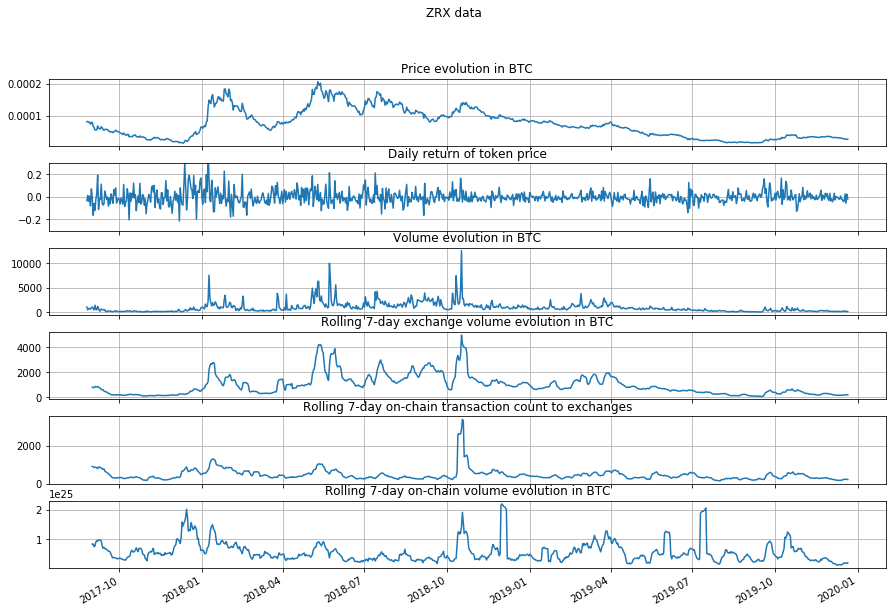

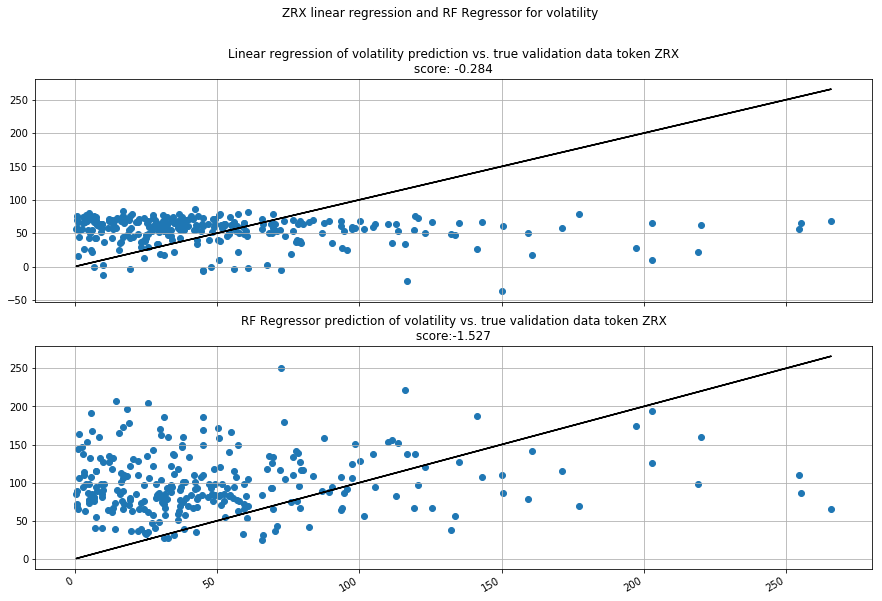

In [12]:
# hardcode our test procedure
compute_for_token('0xe41d2489571d322189246dafa5ebde1f4699f498', 'ZRX')

In [ ]:
# hardcode our test procedure
compute_for_token('0xf629cbd94d3791c9250152bd8dfbdf380e2a3b9c', 'ENJ')

In [ ]:
# hardcode our test procedure
compute_for_token('0x3883f5e181fccaf8410fa61e12b59bad963fb645', 'THETA')

### Run the program for all tokens

### Printing results in LaTeX

### Print ML techniques scores